In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics
from src.reasoner_mod import *
from src.generate import load_dataset, prepare_data
from src.reasoner import *
from src.utils import *
from src.vis import *


In [3]:
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)


In [4]:
data_tr, data_vl, data_te_tr, data_te_vl, idx_te_te, X_te_te, y_te_te = prepare_data(data_tr, data_vl, data_te, seed)

In [5]:
print(np.mean(data_tr[2]))
print(np.mean(data_vl[2]))
print()
print(np.mean(data_te_tr[2]))
print(np.mean(data_te_vl[2]))
print(np.mean(y_te_te))

0.21857221508533675
0.21258330066640532

0.22166126179245282
0.207749766573296
0.20907114010562286


In [6]:
emb_size = 10
hidden_size = 16
epoch_count = 10
test_epoch_count = 10
batch_size = 32

T.manual_seed(seed)
trained_reasoner = ModifiedReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders = [ModifiedEmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]

print(f'created reasoner with {paramcount(trained_reasoner)} parameters')
print(f'created {len(encoders)} encoders with {paramcount(encoders[0])} parameters each')
train_logger = train_mod(data_tr, data_vl, trained_reasoner, encoders, epoch_count=epoch_count,
                          batch_size=batch_size, identities_weight=0.02, identitity_weight_decay=0.95)

created reasoner with 3283 parameters
created 40 encoders with 1270 parameters each
train epoch 00/10 | batch 1704/1703 | loss 0.9680 | val loss 0.7716 | acc 0.2126 | f1 0.3506 | prec 0.2126 | recall 1.0000 | roc auc 0.5113 | pr auc 0.2443 | elapsed 27.67s
train epoch 01/10 | batch 1704/1703 | loss 0.7659 | val loss 0.5138 | acc 0.8133 | f1 0.3201 | prec 0.7086 | recall 0.2067 | roc auc 0.6437 | pr auc 0.4544 | elapsed 53.08s
train epoch 02/10 | batch 1704/1703 | loss 0.5180 | val loss 0.4449 | acc 0.8185 | f1 0.5248 | prec 0.5918 | recall 0.4715 | roc auc 0.7700 | pr auc 0.5984 | elapsed 52.77s
train epoch 03/10 | batch 1704/1703 | loss 0.3828 | val loss 0.4440 | acc 0.8261 | f1 0.5909 | prec 0.5909 | recall 0.5910 | roc auc 0.7999 | pr auc 0.6590 | elapsed 53.27s
train epoch 04/10 | batch 1704/1703 | loss 0.3007 | val loss 0.4627 | acc 0.8246 | f1 0.6087 | prec 0.5789 | recall 0.6417 | roc auc 0.8155 | pr auc 0.6958 | elapsed 53.56s
train epoch 05/10 | batch 1704/1703 | loss 0.2483 |

In [7]:
## --- TESTING
trained_test_encoders = {}
T.manual_seed(seed)
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('trained reasoner', trained_reasoner)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    train_mod(data_te_tr, data_te_vl, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)

trained reasoner
train epoch 00/10 | batch 001/848 | loss 0.9259 | elapsed 0.01s

train epoch 00/10 | batch 849/848 | loss 0.9568 | val loss 1.2374 | acc 0.6433 | f1 0.4200 | prec 0.3172 | recall 0.6217 | roc auc 0.6867 | pr auc 0.4718 | elapsed 6.29s
train epoch 01/10 | batch 849/848 | loss 0.8360 | val loss 1.0823 | acc 0.6673 | f1 0.4429 | prec 0.3396 | recall 0.6367 | roc auc 0.7152 | pr auc 0.5025 | elapsed 11.73s
train epoch 02/10 | batch 849/848 | loss 0.6018 | val loss 0.9658 | acc 0.6869 | f1 0.4646 | prec 0.3603 | recall 0.6539 | roc auc 0.7416 | pr auc 0.5338 | elapsed 11.78s
train epoch 03/10 | batch 849/848 | loss 0.4372 | val loss 0.8825 | acc 0.7043 | f1 0.4840 | prec 0.3796 | recall 0.6674 | roc auc 0.7632 | pr auc 0.5634 | elapsed 11.67s
train epoch 04/10 | batch 849/848 | loss 0.3278 | val loss 0.8232 | acc 0.7193 | f1 0.5039 | prec 0.3981 | recall 0.6861 | roc auc 0.7803 | pr auc 0.5902 | elapsed 11.87s
train epoch 05/10 | batch 849/848 | loss 0.2565 | val loss 0.7796 | acc 0.7288 | f1 0.5176 | prec 0.4104 | recall 0.7004 | roc auc 0.7942 | pr auc

In [8]:
with T.no_grad():
    # idx_te, X_te, y_te = data_te
    _, _, Y_te_good = eval_batch(trained_reasoner, trained_test_encoders['trained reasoner'], X_te_te, y_te_te, idx_te_te)
    # _, _, Y_te_rand = eval_batch(random_reasoner, trained_test_encoders['random reasoner'], X_te, y_te, idx_te)

local/out/exp/20240714T104822


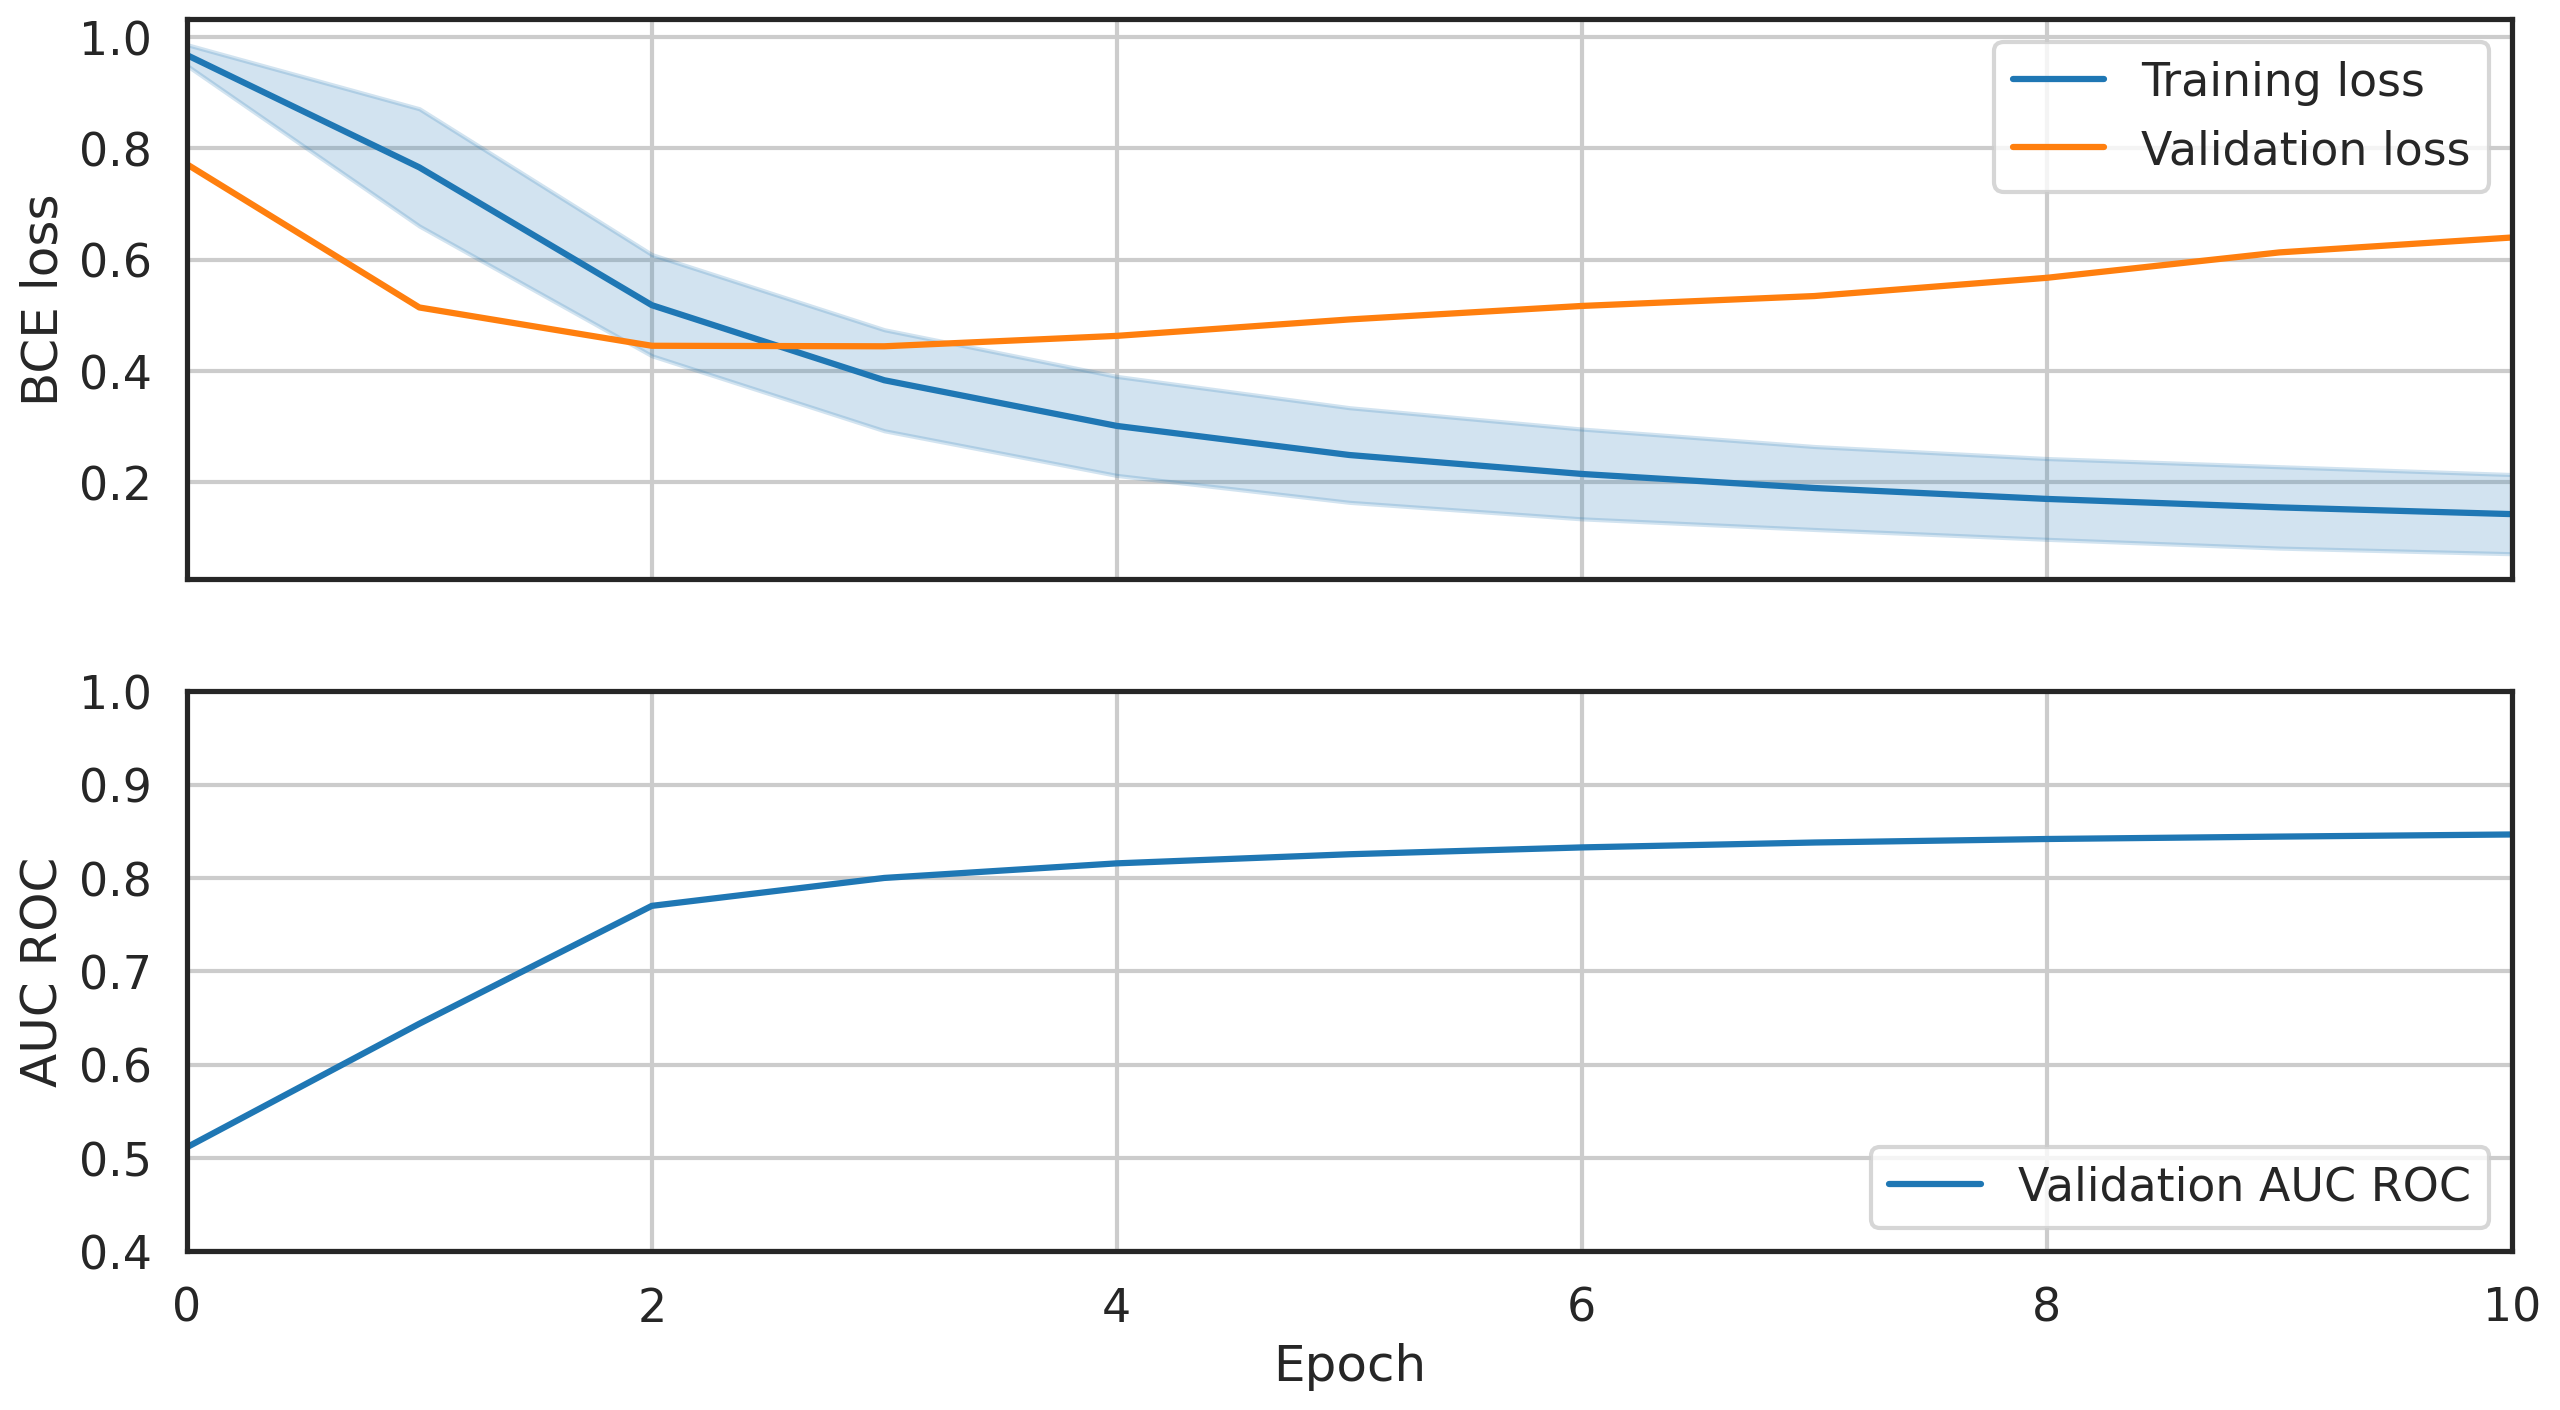

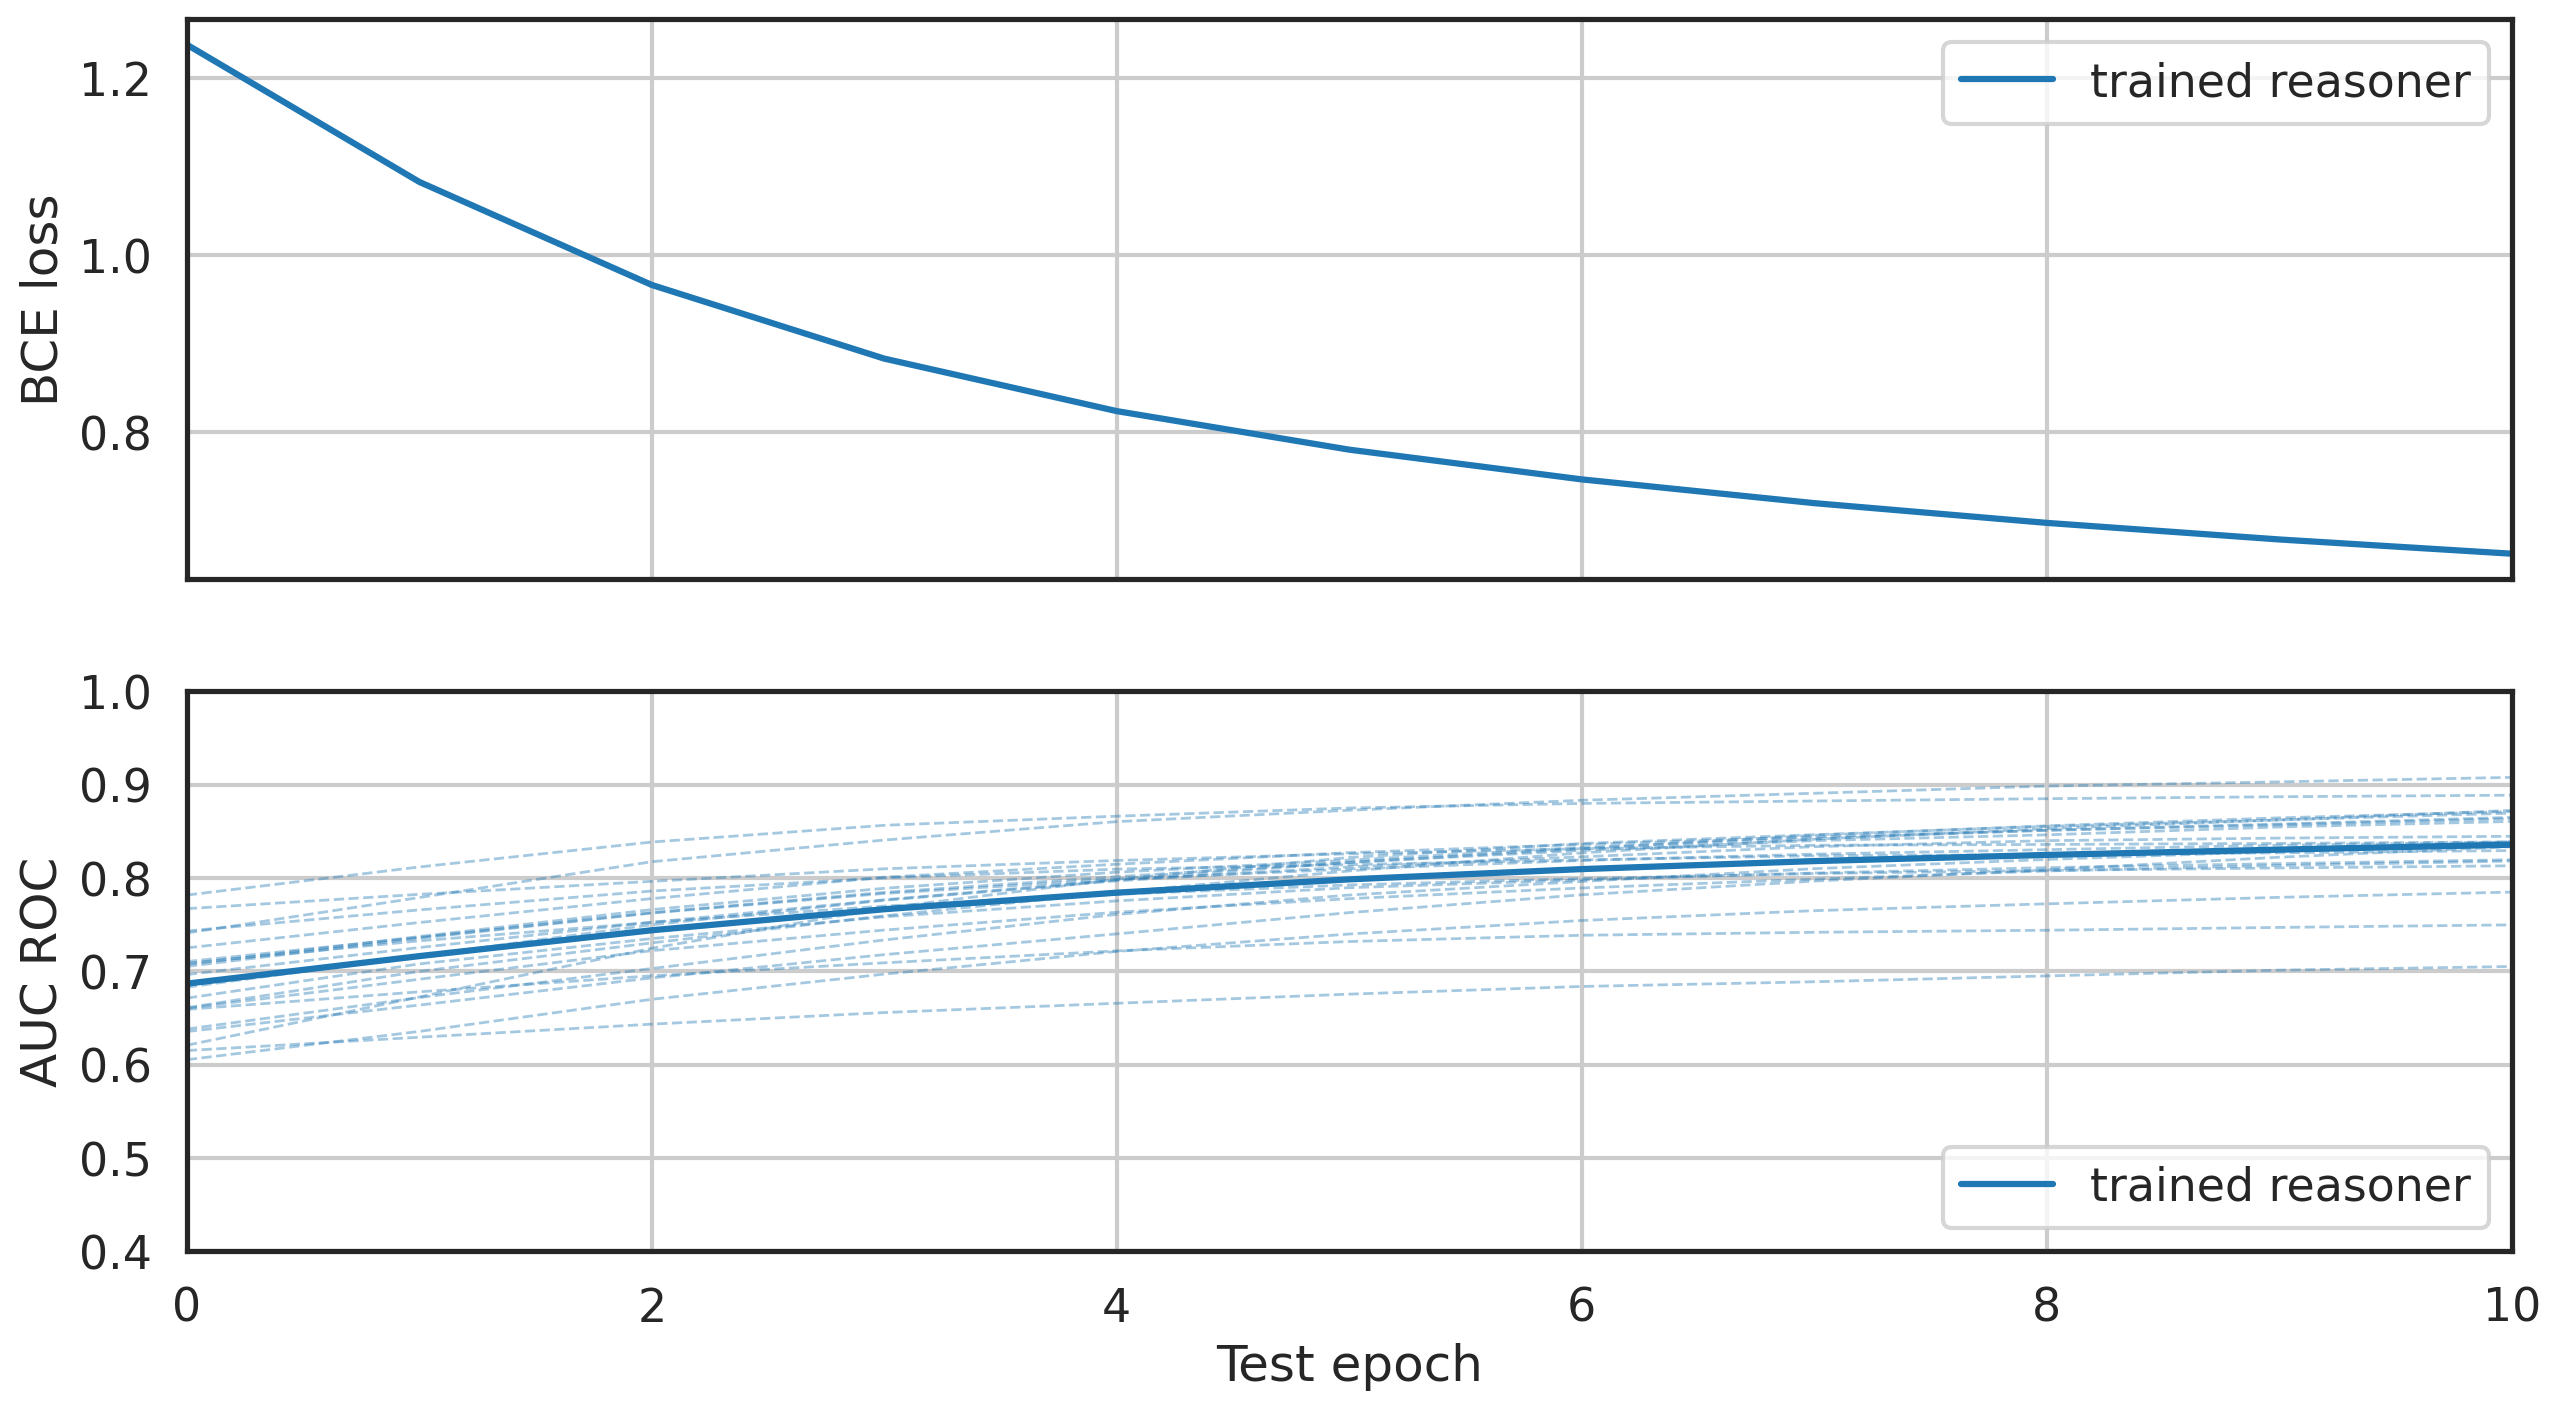

             mean       std     micro
acc      0.779945  0.053674  0.780367
prec     0.489890  0.098184  0.483886
recall   0.766659  0.082452  0.758544
f1       0.591370  0.078782  0.590856
auc_roc  0.857258  0.048986  0.855532
auc_pr   0.735112  0.080146  0.734668


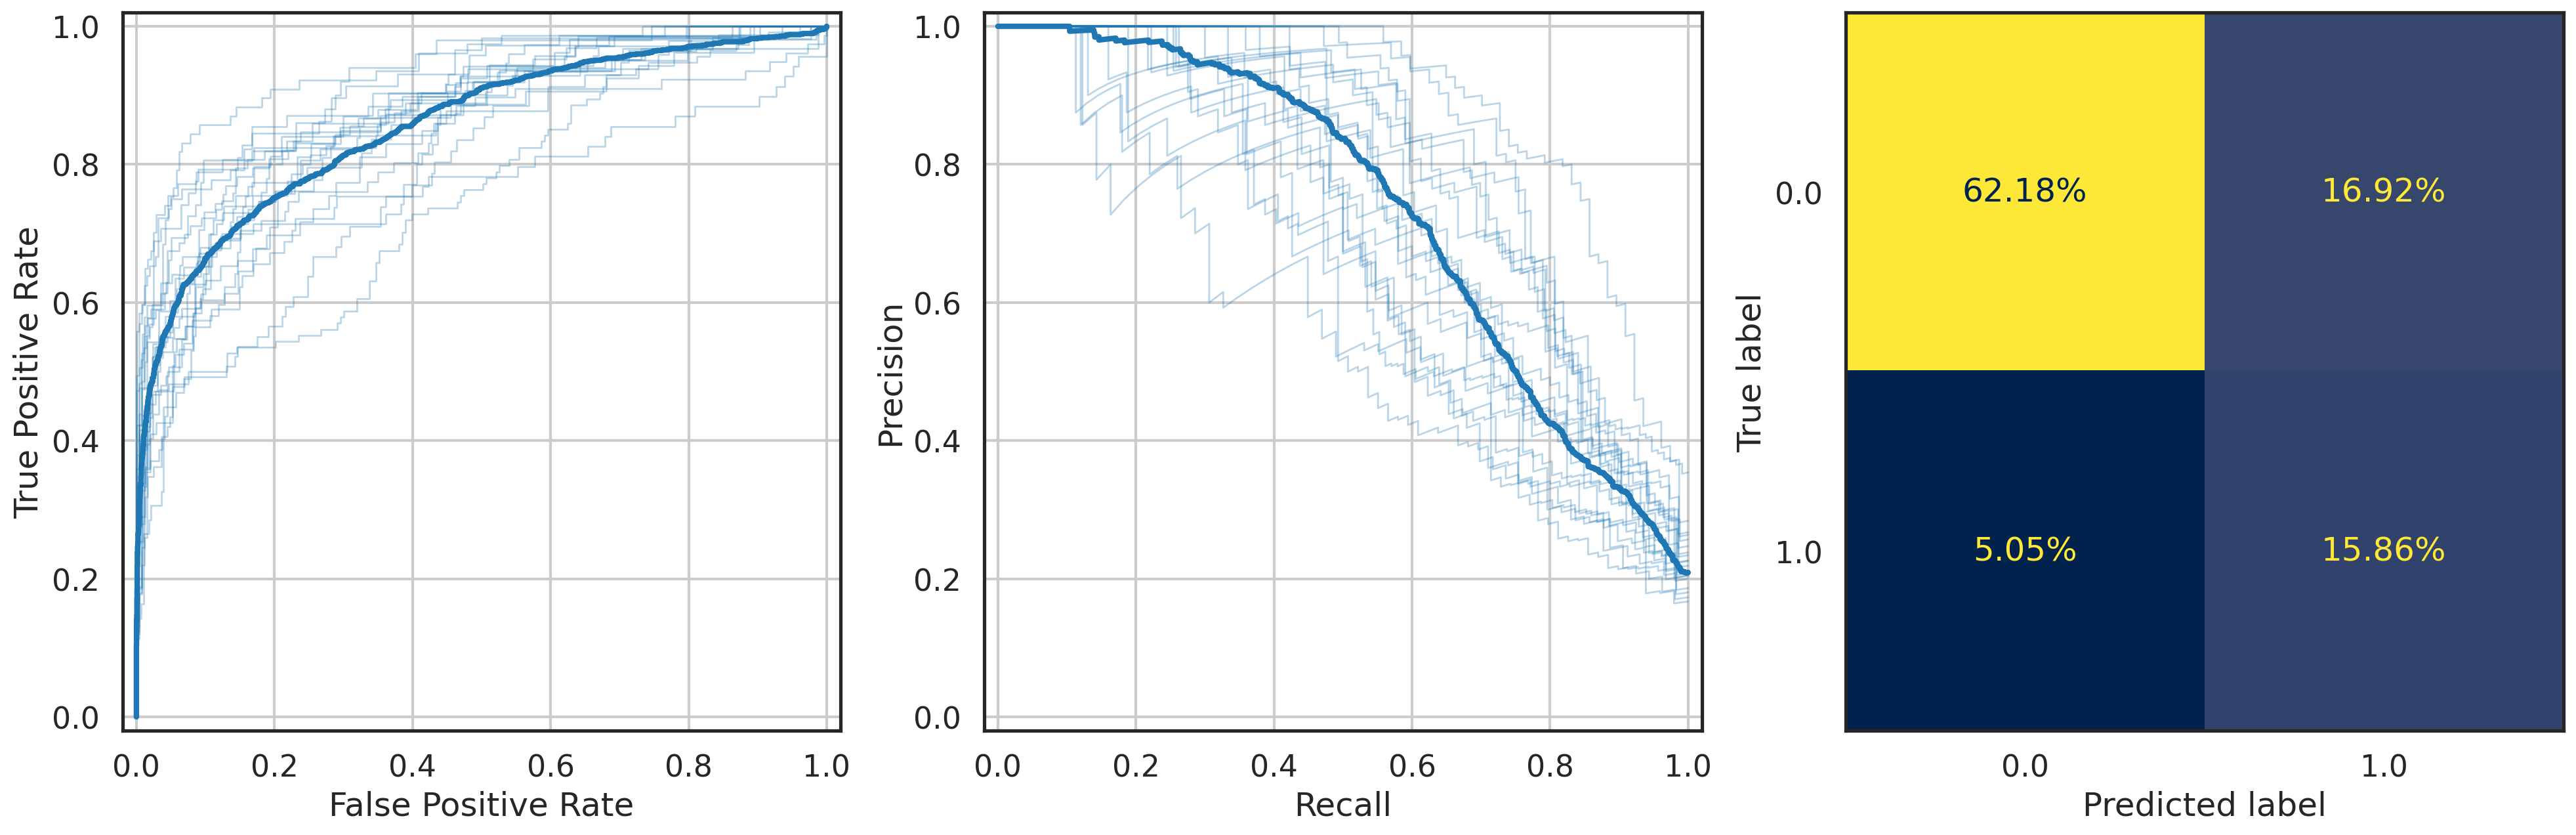

In [9]:
base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

T.save(trained_reasoner.state_dict(), base+'/reasoner.pt')
df_tr = pd.DataFrame(train_logger.history_tr)
df_vl = pd.DataFrame(train_logger.history_vl)
df_tr.to_csv(base+'/train.csv', index=False)
df_vl.to_csv(base+'/valid.csv', index=False)
plot_train_history(df_tr, df_vl, save=base+'/train.png')

test_history_by_onto = pd.DataFrame(test_logger.history_vl_by_onto)
test_history = pd.DataFrame(test_logger.history_vl)
test_results = pd.DataFrame(dict(idx_te=idx_te_te, y_te=y_te_te, Y_te_good=Y_te_good))
test_history.to_csv(base+'/test.csv', index=False)
test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
test_results.to_csv(base+'/test-results.csv', index=False)
plot_test_history(test_history, test_history_by_onto)
print(report(test_onto, y_te_te, np.array(Y_te_good), idx_te_te))
# print(report(test_onto, y_te, np.array(Y_te_rand), idx_te))

In [10]:
import random

In [11]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append( F.l1_loss(input, trained_reasoner.and_nn(im(input, input))).item() )


print(input)
print(trained_reasoner.and_nn(im( input, input)))
print(np.mean(losses))

tensor([ 0.0023, -0.1674,  0.0605,  0.2438,  0.1516, -0.1194, -0.0140, -0.0617,
        -0.0745, -0.0160], grad_fn=<SelectBackward0>)
tensor([ 0.1707, -0.0290,  0.1175, -0.1346,  0.1925, -0.1207, -0.0381, -0.0017,
        -0.0932,  0.0080], grad_fn=<AddBackward0>)
0.13337004110217093


In [12]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append(F.l1_loss(trained_reasoner.and_nn(im(trained_reasoner.bot_concept[0], input)), trained_reasoner.bot_concept[0]).item())
print(trained_reasoner.bot_concept[0])
print(trained_reasoner.and_nn(im(trained_reasoner.bot_concept[0], input)))
print(np.mean(losses))

tensor([ 0.4573,  0.2402,  0.1613, -0.3354,  0.4603, -0.0612,  0.1137,  0.1669,
        -0.2876, -0.2247], grad_fn=<SelectBackward0>)
tensor([ 0.5021,  0.2171,  0.1660, -0.3627,  0.4907, -0.0093,  0.1934,  0.2305,
        -0.3162, -0.2476], grad_fn=<AddBackward0>)
0.0368742891587317


In [13]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append(F.l1_loss(trained_reasoner.and_nn(im(trained_reasoner.top_concept[0], input)), input).item())

print(input)
print(trained_reasoner.and_nn(im(trained_reasoner.top_concept[0], input)))
print(np.mean(losses))

tensor([ 0.0900, -0.0245,  0.2368, -0.0135, -0.1167,  0.0715, -0.1278,  0.0891,
        -0.0681,  0.1008], grad_fn=<SelectBackward0>)
tensor([ 0.1071, -0.0218,  0.0779, -0.0755,  0.0773,  0.0003, -0.0189,  0.0141,
        -0.0487,  0.0136], grad_fn=<AddBackward0>)
0.08641455098986625


In [14]:
losses = []
for _ in range(20):

    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    output = trained_reasoner.and_nn(im(trained_reasoner.not_nn(input), input))
    losses.append(F.l1_loss(trained_reasoner.bot_concept[0], output).item())

print(trained_reasoner.bot_concept[0])
print(output)
print(np.mean(losses))

tensor([ 0.4573,  0.2402,  0.1613, -0.3354,  0.4603, -0.0612,  0.1137,  0.1669,
        -0.2876, -0.2247], grad_fn=<SelectBackward0>)
tensor([ 0.2622, -0.0561,  0.1016, -0.1996,  0.2388, -0.1686, -0.0360, -0.0932,
        -0.0194,  0.0284], grad_fn=<AddBackward0>)
0.1659030694514513


In [15]:
print(trained_reasoner.bot_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.top_concept[0])
print(output)
print(F.l1_loss(trained_reasoner.bot_concept[0], output))

tensor([ 0.4573,  0.2402,  0.1613, -0.3354,  0.4603, -0.0612,  0.1137,  0.1669,
        -0.2876, -0.2247], grad_fn=<SelectBackward0>)
tensor([ 0.4982,  0.2398,  0.1599, -0.3370,  0.4851, -0.0611,  0.1150,  0.1674,
        -0.2999, -0.2248], grad_fn=<SqueezeBackward3>)
tensor(0.0083, grad_fn=<L1LossBackward0>)


In [16]:
print(trained_reasoner.top_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.bot_concept[0])
print(output)
print(F.l1_loss(trained_reasoner.top_concept[0], output))

tensor([-0.0563, -0.3344, -0.0559,  0.4493,  0.0766,  0.3916,  1.1244, -0.0040,
        -0.2020,  0.4374], grad_fn=<SelectBackward0>)
tensor([-0.0563, -0.3348, -0.0589,  0.4326,  0.0764,  0.3924,  1.0635, -0.0039,
        -0.2061,  0.4167], grad_fn=<SqueezeBackward3>)
tensor(0.0107, grad_fn=<L1LossBackward0>)


In [17]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    input3 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    losses.append(F.l1_loss(trained_reasoner.and_nn(im(input1, trained_reasoner.and_nn(im(input2, input3)))), trained_reasoner.and_nn(im(trained_reasoner.and_nn(im(input1, input2)), input3))).item())

print(trained_reasoner.and_nn(im(input1, trained_reasoner.and_nn(im(input2, input3)))))
print(trained_reasoner.and_nn(im(trained_reasoner.and_nn(im(input1, input2)), input3)))
print(np.mean(losses))

tensor([ 0.2907,  0.0166,  0.1357, -0.2546,  0.2498, -0.0735, -0.0221,  0.0383,
        -0.1450, -0.0301], grad_fn=<AddBackward0>)
tensor([ 0.2761,  0.0105,  0.1671, -0.2420,  0.2392, -0.0794,  0.0211,  0.0288,
        -0.1081, -0.0643], grad_fn=<AddBackward0>)
0.020634754188358785


In [18]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    losses.append( F.l1_loss(trained_reasoner.and_nn(im(input1, input2)), trained_reasoner.and_nn(im(input2, input1))).item())

print(trained_reasoner.and_nn(im(input1, input2)))
print(trained_reasoner.and_nn(im(input2, input1)))

print(np.mean(losses))

tensor([ 0.1671, -0.0772,  0.1415, -0.1728,  0.1224, -0.1057, -0.0484, -0.0436,
        -0.0439,  0.0159], grad_fn=<AddBackward0>)
tensor([ 0.1679, -0.0622,  0.1045, -0.1896,  0.1582, -0.1330, -0.0548, -0.0982,
         0.0178,  0.0433], grad_fn=<AddBackward0>)
0.024922489561140536


In [19]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(F.l1_loss(input1, trained_reasoner.and_nn(im(input1, trained_reasoner.top_concept[0]))).item())

print(input1)
print(trained_reasoner.and_nn(im(input1, trained_reasoner.top_concept[0])))

print(np.mean(losses))

tensor([ 0.0435,  0.1862, -0.2438, -0.0568, -0.4317,  0.2344, -0.2577,  0.2687,
         0.2005, -0.0558], grad_fn=<SelectBackward0>)
tensor([ 0.0109, -0.0575, -0.1097, -0.0499, -0.1101, -0.0522, -0.1601,  0.0304,
         0.0826,  0.0563], grad_fn=<AddBackward0>)
0.0814421683549881


In [20]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append( T.sigmoid(trained_reasoner.sub_nn(im(input1, trained_reasoner.top_concept[0]))).item())
print(np.mean(losses))

0.9997271239757538


In [21]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(T.sigmoid(trained_reasoner.sub_nn(im(trained_reasoner.bot_concept[0], trained_reasoner.bot_concept[0]))).item())
print(np.mean(losses))

0.9999747276306152
